In [ ]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.neuralnetworks import SigmoidNeuralNetwork, LogisticRegressionNet
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Paramaters

In [2]:
base_seed = 42
base_feature_size = 12
baseline_accuracy = 0.925

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Neural Network

In [3]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [4]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'module__layer_size': [32, 64],
    'module__layer_no': [1],
    'optimizer__weight_decay': [1e-3, 1e-4],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [5]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 1024, 'max_epochs': 50, 'module__layer_no': 1, 'module__layer_size': 64, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.9638541666666667


### Assesing performance

In [6]:
nn_results = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.959375
Run 2 / 10 started
Run finished with test accuracy: 0.9629166666666666
Run 3 / 10 started
Run finished with test accuracy: 0.9602083333333333
Run 4 / 10 started
Run finished with test accuracy: 0.955625
Run 5 / 10 started
Run finished with test accuracy: 0.9629166666666666
Run 6 / 10 started
Run finished with test accuracy: 0.9647916666666667
Run 7 / 10 started
Run finished with test accuracy: 0.9610416666666667
Run 8 / 10 started
Run finished with test accuracy: 0.95625
Run 9 / 10 started
Run finished with test accuracy: 0.9585416666666666
Run 10 / 10 started
Run finished with test accuracy: 0.9564583333333333


In [7]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.699434        0.507656       0.959375
1     0      1    0.687012        0.557604       0.959375
2     0      2    0.655796        0.663177       0.959375
3     0      3    0.517804        0.782031       0.959375
4     0      4    0.333060        0.889531       0.959375


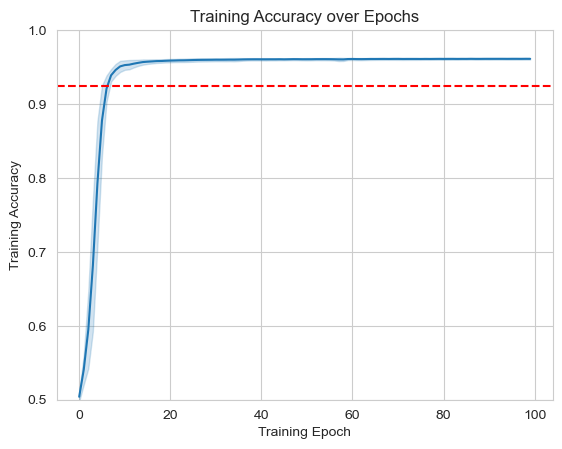

In [8]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

# Random Forrests

In [9]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Assessing Performance

In [10]:
forrest_results = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9616666666666667
Run 2 / 10 started
Run finished with test accuracy: 0.9683333333333334
Run 3 / 10 started
Run finished with test accuracy: 0.9672916666666667
Run 4 / 10 started
Run finished with test accuracy: 0.961875
Run 5 / 10 started
Run finished with test accuracy: 0.9645833333333333
Run 6 / 10 started
Run finished with test accuracy: 0.9670833333333333
Run 7 / 10 started
Run finished with test accuracy: 0.965625
Run 8 / 10 started
Run finished with test accuracy: 0.9629166666666666
Run 9 / 10 started
Run finished with test accuracy: 0.9616666666666667
Run 10 / 10 started
Run finished with test accuracy: 0.963125


In [11]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.961667
1    1       0.968333
2    2       0.967292
3    3       0.961875
4    4       0.964583
5    5       0.967083
6    6       0.965625
7    7       0.962917
8    8       0.961667
9    9       0.963125


In [12]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.9644166666666667
Baseline to beat 0.925


# Logistic Regression

In [9]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Performing Grid Search

In [ ]:
net = NeuralNetClassifier(
    module=LogisticRegressionNet,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

# params = {
#     'optimizer__lr': [0.1, 0.01, 0.001],
#     'max_epochs': [50],
#     'batch_size': [1024],
#     'optimizer__weight_decay': [1e-3, 1e-4],
# }

params = {
    'optimizer__lr': [0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'optimizer__weight_decay': [1e-3],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=1, verbose=2)
clf = gs.fit(X_train, y_train.astype(np.float32))

(19200, 18564) (19200,) 18564
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.8s
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.3s
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.1s
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.1s
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.1s
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.1s
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.1s
[CV] END batch_size=1024, max_epochs=50, optimizer__lr=0.001, optimizer__weight_decay=0.001; total time=   0.1s
[CV] END batc

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\optim\optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\optim\optimizer.py", line 91, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\optim\adam.py", line 202, in step
    loss = closure()
           ^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 993, in train_step_single
    y_pred = self.infer(Xi, **fit_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1521, in infer
    return self.module_(x, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Master's\Mathematics for Machine Learning\Team Repo\Solvers\..\Utils\neuralnetworks.py", line 37, in forward
    return self.layers(x).view(-1)
           ^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: mat1 and mat2 must have the same dtype, but got Half and Float


In [15]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 1500, 'tol': 0.001}
Best accuracy found:  0.5519270833333334


### Assessing Performance

In [16]:
logreg_results = run_multiple_logistics(gs, base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.5541666666666667
Run 2 / 10 started
Run finished with test accuracy: 0.5397916666666667
Run 3 / 10 started
Run finished with test accuracy: 0.5627083333333334
Run 4 / 10 started
Run finished with test accuracy: 0.5514583333333334
Run 5 / 10 started
Run finished with test accuracy: 0.5583333333333333
Run 6 / 10 started
Run finished with test accuracy: 0.5445833333333333
Run 7 / 10 started
Run finished with test accuracy: 0.5308333333333334
Run 8 / 10 started
Run finished with test accuracy: 0.535625
Run 9 / 10 started
Run finished with test accuracy: 0.5514583333333334
Run 10 / 10 started
Run finished with test accuracy: 0.5375


In [17]:
print(logreg_results)

os.makedirs('results', exist_ok=True)
logreg_results.to_csv(f'results/log_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.554167
1    1       0.539792
2    2       0.562708
3    3       0.551458
4    4       0.558333
5    5       0.544583
6    6       0.530833
7    7       0.535625
8    8       0.551458
9    9       0.537500


In [18]:
print("Logistic Regression Accuracy:", logreg_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Logistic Regression Accuracy: 0.5466458333333333
Baseline to beat 0.925
